In [23]:
import os
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt

### Transforms

'''
`transform.Compose` - это класс из библиотеки `torchvision.transforms`, который позволяет объединять несколько трансформаций для применения их к изображению. Ниже приведены возможные преобразования, которые можно использовать в `transform.Compose`:

- `transforms.Resize(size)` - изменение размера изображения до указанного `size`.
- `transforms.CenterCrop(size)` - обрезание изображения по центру до указанного `size`.
- `transforms.RandomCrop(size)` - случайное обрезание изображения до указанного `size`.
- `transforms.RandomHorizontalFlip(p=0.5)` - случайное отражение изображения по горизонтали с вероятностью `p`.
- `transforms.RandomRotation(degrees)` - случайный поворот изображения на указанный угол `degrees`.
- `transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)` - изменение яркости, контраста, насыщенности и тона изображения.
- `transforms.ToTensor()` - преобразование изображения в тензор.
- `transforms.Normalize(mean, std)` - нормализация тензора изображения с помощью указанных средних значений `mean` и стандартных отклонений `std`.
'''

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


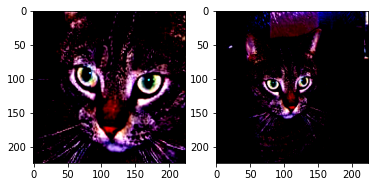

In [32]:
normalize = transforms.Normalize(mean=[0.485, 0.486,0.406],std=[0.229,0.224,0.225])

train_trans = transforms.Compose([
    transforms.RandomRotation(40),
    transforms.Resize([456,456]),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

test_trans = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    normalize
])
p_train = '/home/strike/work/learn/guu/dl_guu_23/07/cats_and_dogs/training_set'
train_data = datasets.ImageFolder(p_train, transform=train_trans)
train_data_test = datasets.ImageFolder(p_train, transform=test_trans)

p_test = '/home/strike/work/learn/guu/dl_guu_23/07/cats_and_dogs/test_set'
test_data = datasets.ImageFolder(p_test, transform=test_trans)

t1 = train_data[0][0]
t2 = train_data_test[0][0]
t1 = t1.transpose(0,2)
t1 = t1.transpose(0,1)
t2 = t2.transpose(0,2)
t2 = t2.transpose(0,1)

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(t1)
ax2.imshow(t2)



Subset

In [14]:
import numpy as np
t = range(len(test_data))
t = np.random.permutation(t)
n = int(len(t)/2)
idx_test = t[:n]
idx_val= t[n:]

val_data = Subset(test_data,idx_test)
test_data = Subset(test_data,idx_val)

DataLoader

In [15]:
train_loader = DataLoader(train_data,batch_size=8,shuffle=True)
test_loader = DataLoader(test_data,batch_size=8,shuffle=False)
val_loader = DataLoader(val_data,batch_size=8,shuffle=False)


Transfer Learning

In [19]:
from torchvision.models import resnet50
resnet18,resnet34, resnet50, 
# model = resnet50(weights=True).cuda()

#for param in model.parameters():
#    param.requires_grad = False

model.fc = nn.Linear(2048,2).cuda()

print(model)

/home/strike/work/env_python/deep/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Train

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.003)
NUM_EPOCH = 2
val_acc=[]
loss_list=[]
train_acc =[]
for epoch in range(NUM_EPOCH):
    loss_sublist = []
    corr = 0
    for x, y in train_loader:
        model.train()
        optimizer.zero_grad()
        x = x.cuda()
        y = y.cuda()
        preds = model(x)
        loss = criterion(preds, y)
        loss_sublist.append(loss.data.item())
        loss.backward()
        optimizer.step()
       
        _, yhat = torch.max(preds.data, 1)
        corr += (yhat == y).sum().item()
        print(".",end='',flush = True )
    
    loss_list.append(np.mean(loss_sublist))
    acc = corr/len(train_data)
    print("Training Accuracy at epoch",epoch+1,"is: ",acc)
    train_acc.append(acc)
    
    correct=0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            model.eval()
            x_test = x_test.cuda()
            y_test = y_test.cuda()
            z = model(x_test)
            _, yhat1 = torch.max(z.data, 1)
            correct += (yhat1 == y_test).sum().item()
    accuracy = correct / len(test_data)
    print("Validation Accuracy at epoch",epoch+1,"is: ",accuracy)
    val_acc.append(accuracy)


...................................................Training Accuracy at epoch 1 is:  0.9850746268656716
Validation Accuracy at epoch 1 is:  1.0
...................................................Training Accuracy at epoch 2 is:  1.0
Validation Accuracy at epoch 2 is:  1.0


### Графики

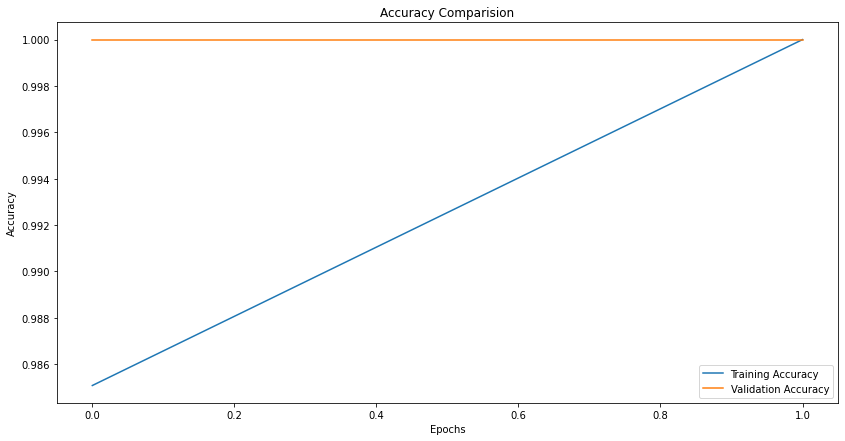

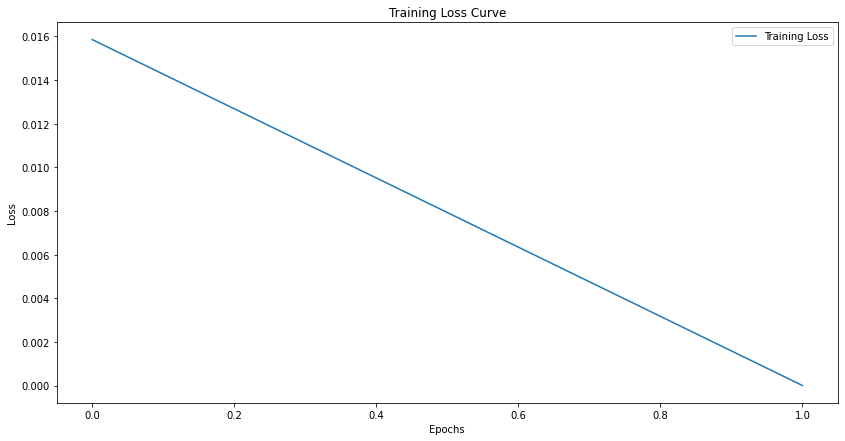

In [21]:
plt.figure(figsize=(14,7))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Comparision')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.figure(figsize=(14,7))
plt.plot(loss_list,label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')##
plt.legend()


### Сохранение обученной модели

In [ ]:
!mkdir models
!mkdir models/pytorch
torch.save(model.state_dict(), 'models/pytorch/model.pth')